In this notebook, we compute climate-optimized trajectories using a quantum circuit. The general idea is that we draw a sample from a subspace of physically feasible trajectories as a preprocessing step and then use Grover's search algorithm to determine the best trajectory. 

# Import Libraries

In [1]:
import sys
sys.path.append("/home/felix/PycharmProjects/Quantum-Challenge/")
import pandas as pd
import xarray as xr
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import traceback
import math
import networkx as nx
import itertools
from qiskit.algorithms import AmplificationProblem
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover
from qiskit.circuit.library import GroverOperator
from qiskit.extensions import Initialize
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram
from itertools import product 
from qiskit.quantum_info import Statevector
from importlib import reload
import utils.utils as ut
import copy
import matplotlib.patheffects as pe

# Load flight Data 

In [2]:
flight_df = pd.read_csv("../data/flights.csv", sep=";")

# Load velocity and fuel consumption data

In [3]:
cruise_df = pd.read_pickle("../data/cruise_df.pkl")
climb_df = pd.read_pickle("../data/climb_df.pkl")
descent_df = pd.read_pickle("../data/descent_df.pkl")

# Load climate data

In [4]:
climate_df = pd.read_pickle("../data/climate_df.pkl")

# Quantum Trajectory Optimization

In [5]:
G = nx.read_gpickle("../data/w_graph.pkl")

Each node in the graph has a set of edges whose weight is the climate cost of traveling from one voxel center to another.
As an example, take the node (4,4,4) with the following Edges:

- (3, 4, 4): {'w': 103.63} 
- (4, 3, 4): {'w': 134.84} 
- (5, 4, 4): {'w': 103.67} 
- (4, 5, 4): {'w': 135.80}
- (3, 4, 3): {'w': 112.62}
- (5, 4, 5): {'w': 102.56}

For this specific node, a given aircraft has the option to change the $x$ coordinate by $\pm 2 ^{\circ}$, the $y$ coordinate by $\pm 2 ^{\circ}$, or the $x$ coordinate by $\pm 2 ^{\circ}$ and the $z$ coordinate by $\pm 20 FL$.



Start the optimization by selecting a flight from the flight plan. In the following example, we find the climate optimal flight path for the flight with index 10. Then we select one of 16 possible final altitudes and create random paths from the starting point to the final point. Then we use the quantum search algorithm to find the best trajectory in this intermediate step to find the climate optimal trajectory at a single final altitude. The random trajectories are colored blue, and the best trajectory is highlighted in yellow.

In [19]:
random_path_arr = ut.gen_rand_path_z(G, z_e=300, s_inx=10, size=50, n_qubits=4)

In [24]:
best_path_z = ut.find_best_path(random_path_arr, n_qubits = 4, run_hardware=False)

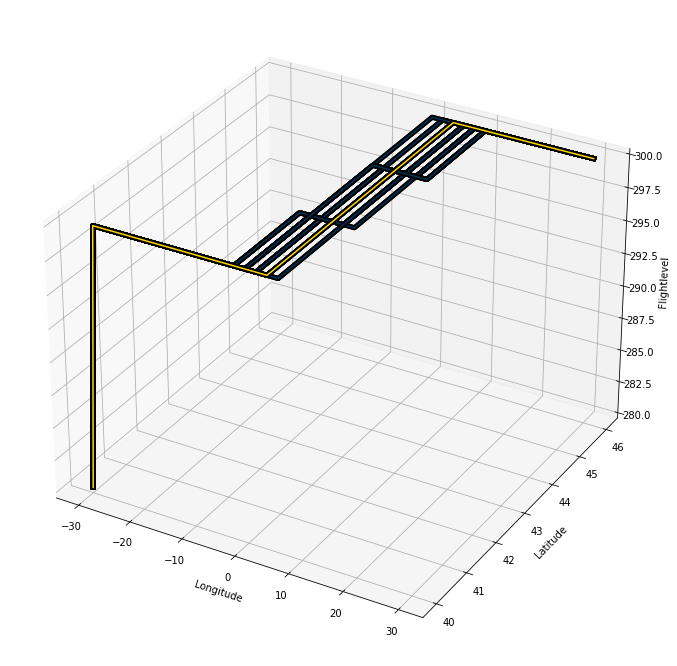

In [26]:
ut.plot_paths(random_path_arr, 4, best_path_z)

This process is then repeated for all possible final trajectories to find the best one at each final altitude. Then a final quantum search is applied to the heap to determine the superior best.

In [ ]:
best_path_arr = ut.gen_rand_path_all_z(G, s_inx=10, size=2, n_qubits=4, run_hardware=False)

In [40]:
best_path = ut.find_best_path(best_path_arr, 4, run_hardware=False)   

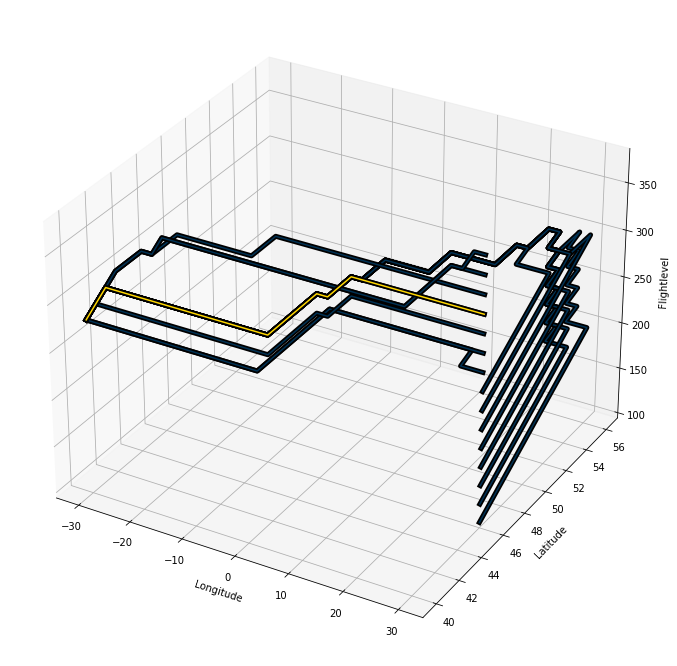

In [41]:
ut.plot_paths(best_path_arr, 4, best_path)

# Compute performance metric of flight schedule

In [42]:
final_traj_arr_t = np.load("../data/final_traj_arr.npy",allow_pickle=True)

In [43]:
classical_climate_delta_T = np.sum([ut.C(tr) for tr in np.array(final_traj_arr_t,dtype=object)[:,1]])
classical_climate_delta_T

5.6385113547554625e-06

In [44]:
np.sum([ut.consumed_fuel(tr)[0] for tr in np.array(final_traj_arr_t,dtype=object)[:,1]])

1954337.3806987768

In [45]:
np.sum([ut.time_traveled(tr)for tr in np.array(final_traj_arr_t,dtype=object)[:,1]])

numpy.timedelta64(2758654,'s')

# Run on hardware

In [6]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)

Running on current least busy device:  ibmq_manila


In [7]:
random_path_arr = ut.gen_rand_path_z(G, z_e=300, s_inx=10, size=16, n_qubits=4)

In [8]:
best_path_z = ut.find_best_path(random_path_arr, n_qubits = 4, run_hardware=True, device = device)

/home/felix/anaconda3/envs/vae-wavefunctions/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:695: UserWarning: max_credits is not a recognized runtime option and may be ignored by the backend.
  return backend.run(circuits, **run_kwargs)


KeyboardInterrupt: 

In [ ]:
ut.plot_paths(best_path_arr, 4, best_path)